In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

np.set_printoptions(suppress=True)

%matplotlib inline

Original arrangement:  ['data/img4.jpg', 'data/img3.jpg', 'data/.ipynb_checkpoints', 'data/img2.jpg', 'data/img1.jpg']
Sorted arrangement:  ['data/img1.jpg', 'data/img2.jpg', 'data/.ipynb_checkpoints', 'data/img3.jpg', 'data/img4.jpg']

Img shape: (664 x 1000)


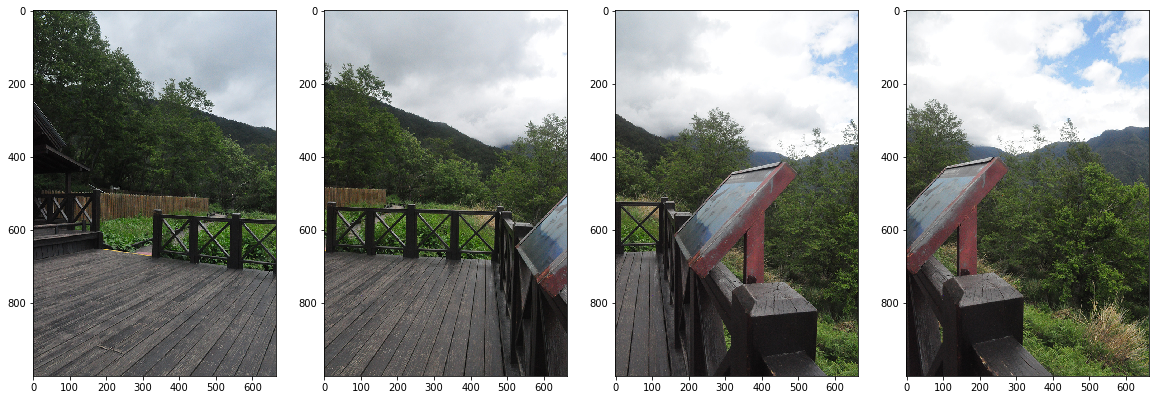

In [2]:
# (1) Load successive images (successive frames: [ fr0, fr1, fr2, fr3 ])

# Note: (taken from same viewpoint center but if the points are faw away, it does not matter much)
# Note: data source => https://github.com/SSARCandy/panoramas-image-stitching/tree/master/input_image/Xue-Mountain-Enterance

root = 'data'
files = []
for filename in os.listdir(root):
    files.append(os.path.join(root, filename))

print('Original arrangement: ', files)
# sort them in reverse
files = files[::-1]
print('Sorted arrangement: ', files)

frames = []
for idx in range(len(files)):
    if not files[idx].endswith('jpg'):
        continue
    frames.append(cv2.cvtColor(cv2.imread(files[idx], cv2.IMREAD_ANYCOLOR), cv2.COLOR_BGR2RGB).astype(np.uint8))
    
IMG_W = frames[0].shape[1]; IMG_H = frames[0].shape[0]
print(f'\nImg shape: ({IMG_W} x {IMG_H})')

N = len(frames)
fig, axes = plt.subplots(1, N, figsize=(20, 20))
for idx in range(N):
    axes[idx].imshow(frames[idx])

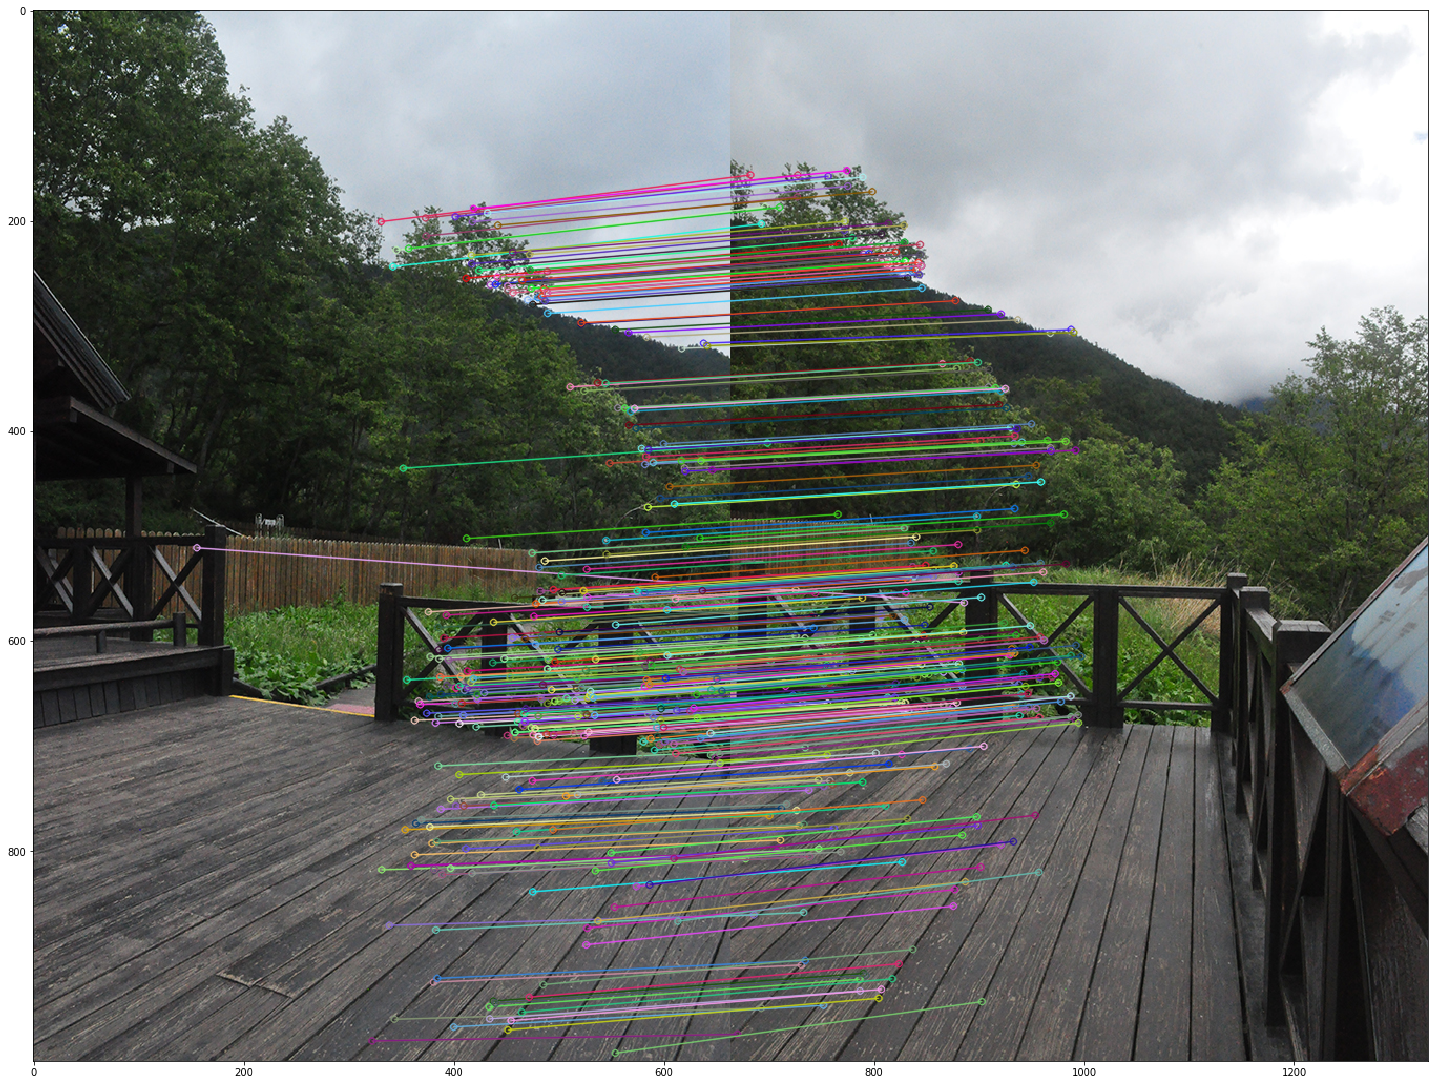

In [3]:
# (2) Find corresponding points in successive frames (relative to base frame, fr0)

sift = cv2.SIFT_create()

kpnts0, descs0 =sift.detectAndCompute(frames[0], None)
kpnts1, descs1 = sift.detectAndCompute(frames[1], None)

index_params = dict(algorithm = 0, trees = 5) 
search_params = dict() 

flann = cv2.FlannBasedMatcher(index_params, search_params)
 
matches= flann.knnMatch(descs0, descs1, k=2) 
  
THRESH = 0.6
    
good_points=[] 
for m, n in matches: 
    if(m.distance < THRESH * n.distance): 
        good_points.append(m) 
        
result = cv2.drawMatches(frames[0], kpnts0, frames[1], kpnts1, good_points, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(25, 25))
plt.imshow(result)

0 => 155.44410705566406 x 511.2642517089844 - 221.92166137695312 x 563.4420166015625
20 => 368.9945373535156 x 770.0038452148438 - 52.92271423339844 x 755.09765625
40 => 386.20220947265625 x 616.8251342773438 - 70.5380859375 x 597.1165771484375
60 => 405.3084716796875 x 642.8820190429688 - 91.14319610595703 x 623.12939453125
80 => 418.92266845703125 x 188.53399658203125 - 110.33375549316406 x 152.22998046875
100 => 447.4696044921875 x 254.43389892578125 - 139.29713439941406 x 226.12969970703125
120 => 461.01727294921875 x 676.5960693359375 - 149.20693969726562 x 653.4712524414062
140 => 474.85552978515625 x 732.8678588867188 - 162.477294921875 x 707.9158935546875
160 => 484.21807861328125 x 594.9885864257812 - 172.10804748535156 x 571.8283081054688
180 => 494.9939880371094 x 550.9956665039062 - 185.31976318359375 x 527.8895263671875
200 => 518.5101928710938 x 671.531982421875 - 206.00457763671875 x 644.6467895507812
220 => 530.1573486328125 x 647.71826171875 - 217.0149383544922 x 621.3

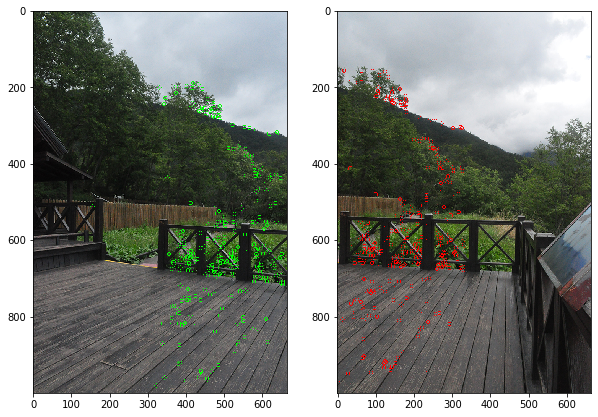

In [4]:
# (2.1) Manage the matching pairs
correspondances = []
for idx in range(len(good_points)):
    match = good_points[idx]
    pnt1 = kpnts0[match.queryIdx]
    pnt2 = kpnts1[match.trainIdx]
    x1, y1 = pnt1.pt
    x2, y2 = pnt2.pt
    correspondances.append([x1, y1, x2, y2])
    
    if idx % 20 == 0:
        print(f'{idx} => {x1} x {y1} - {x2} x {y2}')
    
correspondances = np.array(correspondances)
#correspondances[:, 0::2] /= IMG_W
#correspondances[:, 1::2] /= IMG_H
print(f'\nStacked correspondances:\n{correspondances.shape}\n')
print(f'\ncorrespondances[0]:\n{correspondances[0]}')
    
base = np.copy(frames[0])
for pnts in correspondances:
    base = cv2.circle(base, (int(pnts[0]), int(pnts[1])), 5, (0, 255, 0))
    
frame = np.copy(frames[1])
for pnts in correspondances:
    frame = cv2.circle(frame, (int(pnts[2]), int(pnts[3])), 5, (255, 0, 0))

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(base)
axes[1].imshow(frame)

In [5]:
# (3) Clean outliers (mismatches) via RANSAC
num_data_pnts = correspondances.shape[0]
prob_outliers = 0.2 # e
termination_count = (1.0 - prob_outliers) * num_data_pnts # T
num_pnts_per_sample = 4 # s
p = 0.99 # probability of only inliers (1 in 100 outliers in this case)
N = np.int(np.ceil(np.log(1.0 - p) / np.log(1.0 - (1.0 - prob_outliers)**num_pnts_per_sample)))

# Note: What is the probability have to be equal to, if going through each pair?
print(f'Terminate at: {termination_count}')
print(f'N: {N}')

Terminate at: 264.0
N: 9


In [18]:
DEBUG = True

def argminwhere(mat):
    rows, cols = mat.shape
    min_vals = []
    min_coords = []
    for col in range(cols):
        min_row = np.argmin(mat[:, col])
        min_coords.append([ min_row, col ])
        min_vals.append(mat[int(min_row)][int(col)])
    
    min_val_abs = [100000, 0]
    for idx in range(len(min_vals)):
        min_val = min_vals[idx]
        if min_val < min_val_abs[0]:
            min_val_abs = [ min_val, min_coords[idx] ]
            
    return np.array([ min_val_abs[1] ])
        
'''
    constraint: ||h|| = 1 (orthogonal matrix) => 9 dofs become 8 dofs
    |-x0, -y0, -1.0, 0.0, 0.0, 0.0, x0 * x1, y0 * x1, x1| |h1|
    |0.0, 0.0, 0.0, -x0, -y0, -1.0, x0 * y1, y0 * y1, y1|.|h2| = 0
                                                          |h3|
                                                          |h4|
                                                          |h5|
                                                          |h6|
                                                          |h7|
                                                          |h8|
                                                          |h9|
    Ah = 0
    AtAh = At.0 = 0
    argmin(h)(AtAh) = h_hat
    d(AtAh)/dh = 0 = AtA => find smallest eigenvalue (minimum)
    Smallest eigenvalue corresponds to the smallest eigenvenvector.
    So, if v_smallest = h => this h will minimize Ah = 0
    One could use, svd(A) = u*e*vt where vt is the transpose of v,
    containing the eigenvectors
'''
def A_i(x0, y0, x1, y1):
    return np.array([ 
        [-x0, -y0, -1.0, 0.0, 0.0, 0.0, x0 * x1, y0 * x1, x1], 
        [0.0, 0.0, 0.0, -x0, -y0, -1.0, x0 * y1, y0 * y1, y1]])

def compute_homography(pairs):
    fr_0 = pairs[0][:2]
    fr_1 = pairs[0][2:]
    x0 = fr_0[0]; y0 = fr_0[1]; x1 = fr_1[0]; y1 = fr_1[1]
    A = A_i(x0, y0, x1, y1)
    
    for idx in range(1, pairs.shape[0]):
        fr_0 = pairs[idx][:2]
        fr_1 = pairs[idx][2:]
        x0 = fr_0[0]; y0 = fr_0[1]; x1 = fr_1[0]; y1 = fr_1[1]
        A = np.vstack([A, A_i(x0, y0, x1, y1)])
        
    U, singular_values, Vt = np.linalg.svd(A, full_matrices=True)
    V = Vt.T
    
    if DEBUG:
        print(f'{U.shape}')
        print(f'{singular_values.shape}')
        print(f'{V.shape}')
    
    # Note: Not necessary to compute the minimum of the matrix, as it is sorted in 
    # decreasing order, from max to min => last column is the smallest eigevector
    #min_idx = argminwhere(v)
    #min_coord  = np.argwhere(np.abs(V) == np.abs(V).min())
    return V[:, -1] #V[:, min_coord[0][1]]

eps = 3 # 3 pixels
for _ in range(50):
    random_pairs = correspondances[np.random.choice(correspondances.shape[0], size=num_pnts_per_sample)]
    H = compute_homography(random_pairs).reshape(3, 3)
    
    for idx in range(random_pairs.shape[0]):
        pnts0 = np.hstack([random_pairs[idx, :2], 1]).reshape(3, 1)
        pnts1 = np.hstack([random_pairs[idx, 2:], 1]).reshape(3, 1)
        
        pred_pnts1 = H.dot(pnts0)
        pred_pnts1 /= pred_pnts1[-1]
        
        if DEBUG:
            print('pnts0: ', pnts0.flatten())
            print('pnts1: ', pnts1.flatten())
            print('pred pnts1: ', pred_pnts1.flatten())
            print('\n')
            raise('DEBUG enabled')
        
        # compare distances (p, gt)
        # count inliers (ones falling within dist_thresh)
    # choose the H with most inliers

(8, 8)
(8,)
(9, 9)
pnts0:  [474.14361572 264.38031006   1.        ]
pnts1:  [165.87045288 238.30749512   1.        ]
pred pnts1:  [165.87045288 238.30749512   1.        ]




TypeError: exceptions must derive from BaseException